In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math, operator

import warnings
warnings.filterwarnings('ignore')

# визуализация процесса apply
from tqdm import tqdm
tqdm.pandas()

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard
from keras_tqdm import TQDMNotebookCallback

seed = 48
np.random.seed(seed) # фиксируем seed

Using TensorFlow backend.


In [2]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [3]:
series = pd.read_csv('pollution.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

In [4]:
series["unix_timestamp"] = series.index.astype(np.int64) // 10**9

In [5]:
series.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,unix_timestamp
date,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,1262390400
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,1262394000
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,1262397600
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,1262401200
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0,1262404800


In [6]:
series.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain', 'unix_timestamp'],
      dtype='object')

In [7]:
df = series[["pollution","rain","snow"]]
df = (df - df.min()) / (df.max() - df.min())

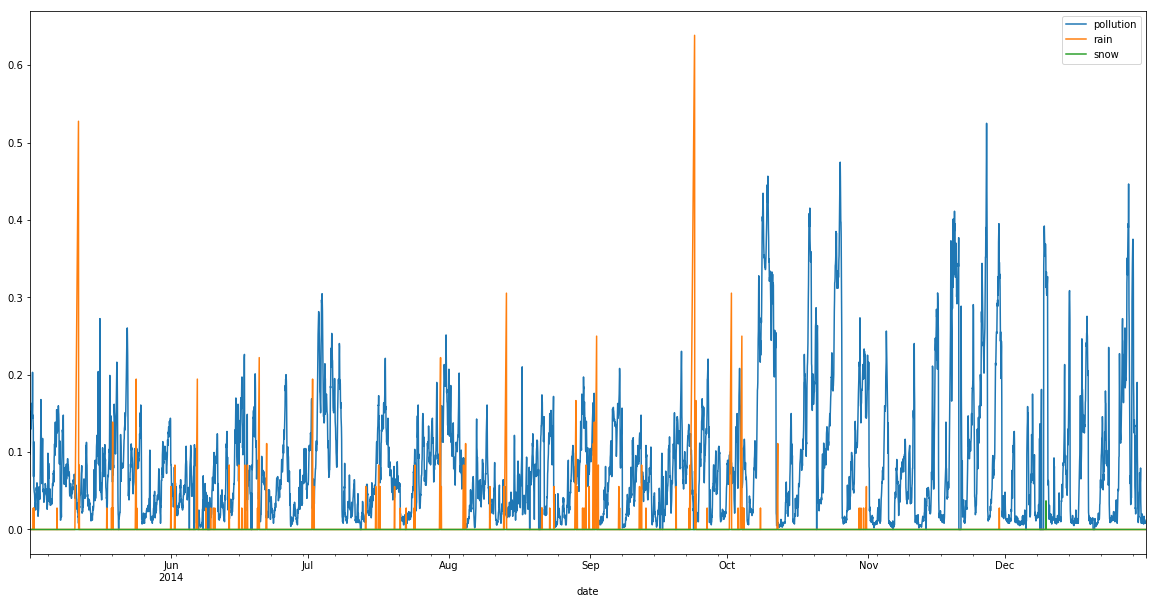

In [8]:
df[df.index>"2014-05-01"].plot(figsize=(20,10))

In [9]:
df = series[["pollution","temp","press"]]
df = (df - df.min()) / (df.max() - df.min())

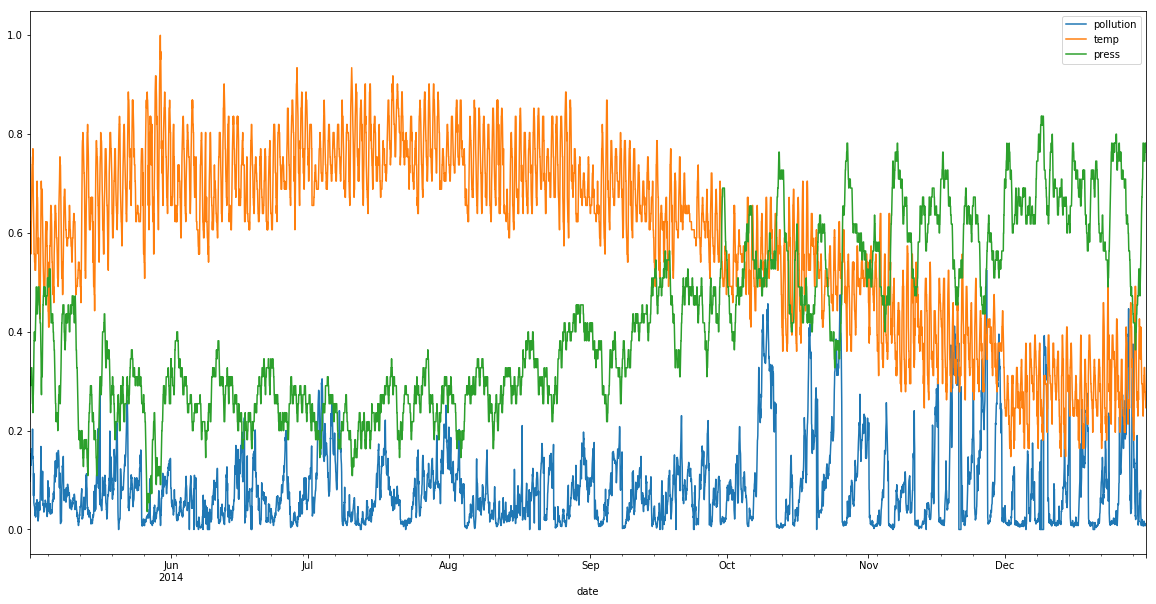

In [10]:
df[df.index>"2014-05-01"].plot(figsize=(20,10))

In [11]:
df = series[["pollution","wnd_spd"]]
df = (df - df.min()) / (df.max() - df.min())

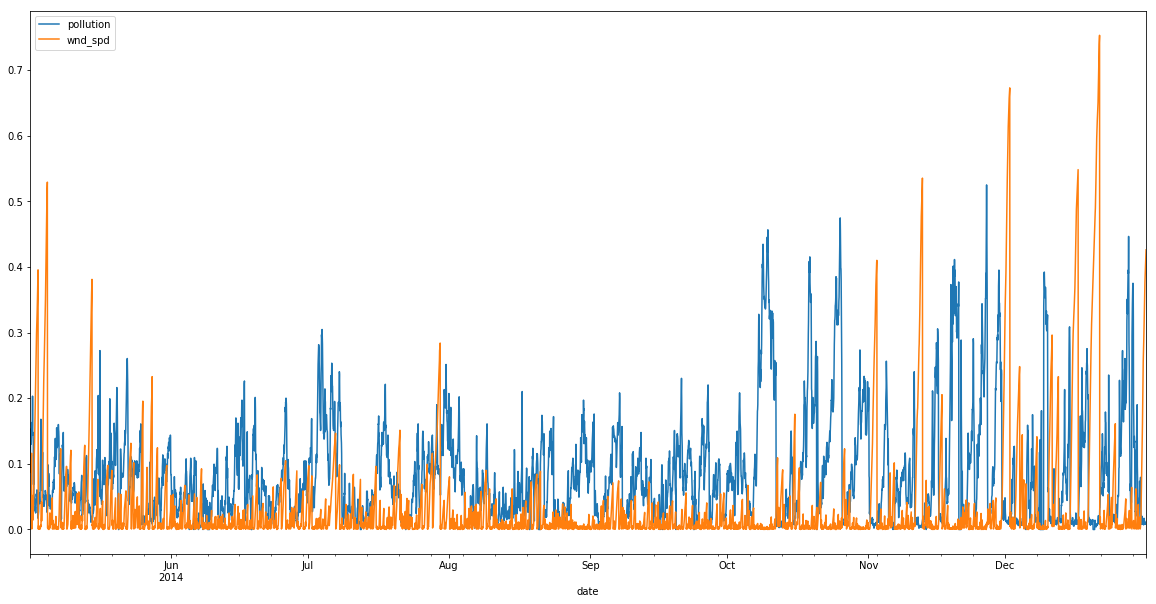

In [12]:
df[df.index>"2014-05-01"].plot(figsize=(20,10))

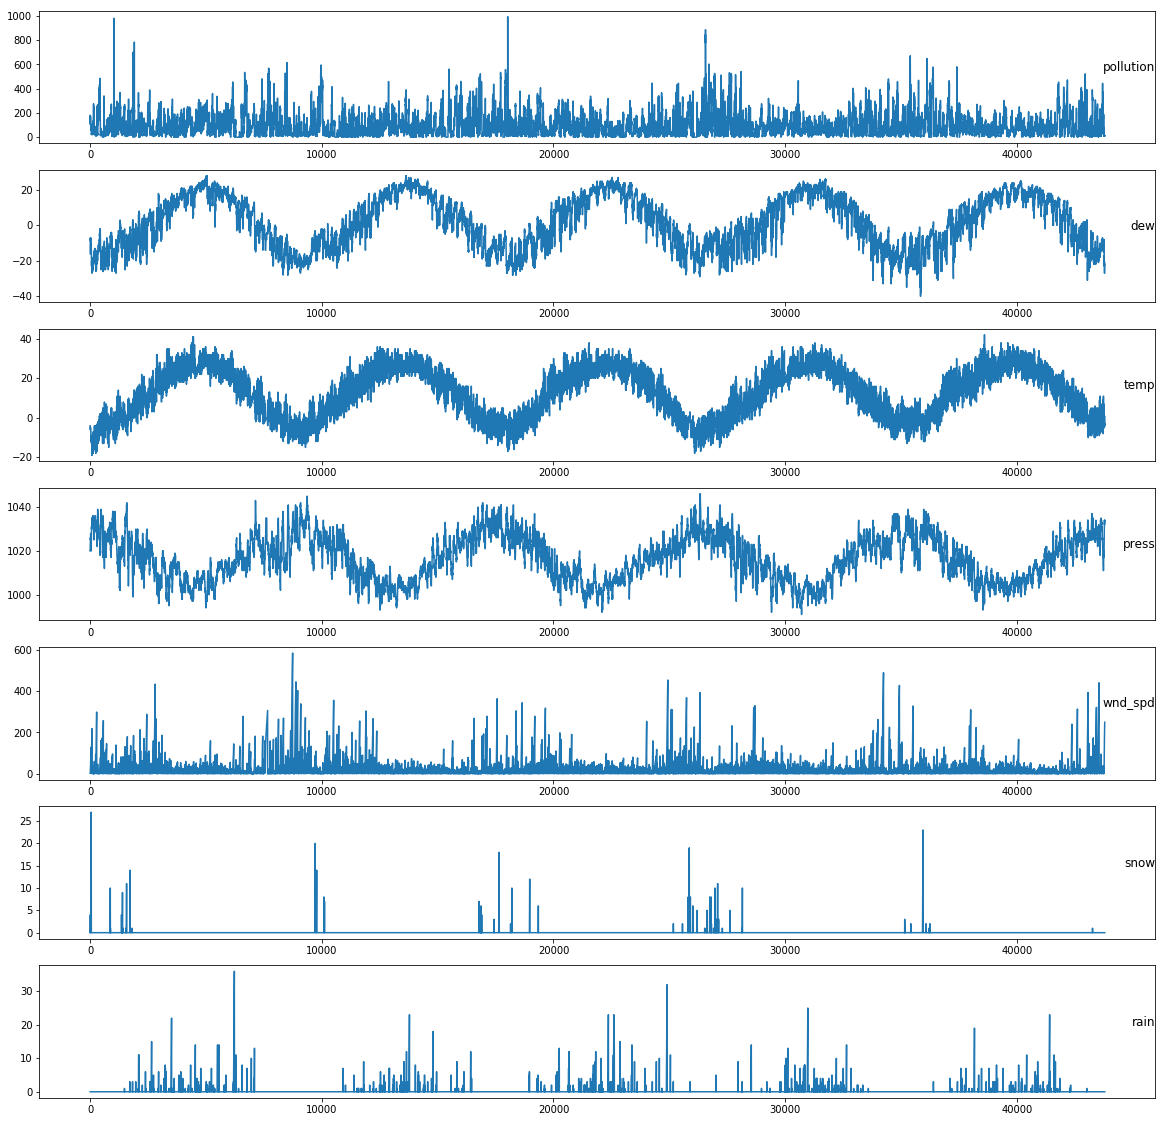

In [13]:
# load dataset
values = series.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(20,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(series.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

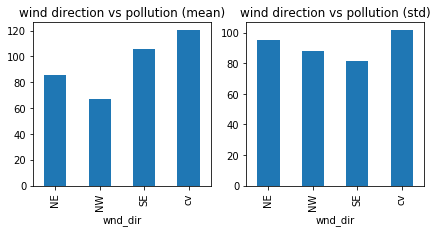

In [14]:
data = series
f,ax=plt.subplots(1,2,figsize=(7,3))

data.groupby(['wnd_dir'])['pollution'].mean().plot.bar(ax=ax[0])
ax[0].set_title('wind direction vs pollution (mean)')

data.groupby(['wnd_dir'])['pollution'].std().plot.bar(ax=ax[1])
ax[1].set_title('wind direction vs pollution (std)')

plt.show()

### Feature Engineering

In [15]:
from tsfresh.feature_extraction.feature_calculators import absolute_sum_of_changes, mean_change

In [16]:
window1 = int(5)
features=["wnd_spd","temp"]
feature_name = "_mean_change"

add_feat = series[features].rolling(window1).progress_apply(mean_change).reset_index()
add_feat.columns = ["date"]+[c+feature_name + "_window" + str(window1) for c in features]
add_feat=add_feat.set_index(["date"],drop=True)
series = series.merge(add_feat, left_index=True, right_index=True, how="left")

87592it [00:01, 69200.52it/s]


In [17]:
# convert time series into supervised learning problem
def series_to_supervised(data, features, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols1, cols2, names1, names2 = list(), list(), list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols1.append(df.shift(i))
        names1 += [(features[j]+'(t-%d)' % i) for j in range(n_vars)]
        cols2.append(df.shift(1).diff(i))
        names2 += [(features[j]+'_d(t-%d)' % i) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols1.append(df.shift(-i))
        cols2.append(df.diff(-i))
        if i == 0:
            names1 += [(features[j]+'(t+0)') for j in range(n_vars)]
            names2 += [(features[j]+'_d(t+0)') for j in range(n_vars)]
        else:
            names1 += [(features[j]+'(t+%d)' % i) for j in range(n_vars)]
            names2 += [(features[j]+'_d(t+%d)' % i) for j in range(n_vars)]
    # put it all together
    agg1 = pd.concat(cols1, axis=1)
    agg1.columns = names1
    agg2 = pd.concat(cols2, axis=1)
    agg2.columns = names2
    agg = pd.concat([agg1,agg2],axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Additional preprocessing

1. Category features encoding by using Target encoding (month, weekday, hour)

2. Make stationary time series from features and target. Differeces and Box-Cox transform for variance

In [18]:
# transform series into train and test sets for supervised learning
def preprocessing_data(series, cols_to_drop, target, n_train, n_lag, n_seq):
    # extract raw values
    series = series.dropna(how="any", axis=0)
    series = series.drop(cols_to_drop, axis=1)

    max_window=5
    train, test = series[0:n_train], series[n_train+max_window:]
    # you can add validation part too
    # series[n_train+largest_window:], prevent overfitting to nearest points to train

    train_y = train[target]
    train_x = train.drop(target, axis=1)
    train_time = pd.DataFrame(train.index)
    test_y = test[target]
    test_x = test.drop(target, axis=1)
    test_time = pd.DataFrame(test.index)

    features = train_x.columns
    cat_features=["wnd_dir"] # to be label encoded

    encoder = LabelEncoder()
    train_x[cat_features] = encoder.fit_transform(train_x[cat_features])
    test_x[cat_features] = encoder.transform(test_x[cat_features])

    scaler_x = MinMaxScaler(feature_range=(0,1))
    train_x = scaler_x.fit_transform(train_x)
    test_x = scaler_x.transform(test_x)

    scaler_y = MinMaxScaler(feature_range=(0,1))
    train_y = scaler_y.fit_transform(train_y)
    test_y = scaler_y.transform(test_y)

    train_x = series_to_supervised(train_x, features, n_lag, n_for)
    test_x = series_to_supervised(test_x, features, n_lag, n_for)
    train_time = series_to_supervised(train_time, ["date"], n_lag, n_for)
    train_y = series_to_supervised(train_y, target, n_lag, n_for)
    test_y = series_to_supervised(test_y, target, n_lag, n_for)
    test_time = series_to_supervised(test_time, ["date"], n_lag, n_for)

    searchfor = ["(t\+"+str(i)+")" for i in range(0,n_for)]+["_d(t\+"+str(i)+")" for i in range(0,n_for)]
    features_x = ~train_x.columns.str.contains('|'.join(searchfor))
    target_cols = [target[0]+"(t+"+str(i)+")" for i in range(0,n_for)]
    lag_cols = [target[0]+"(t-"+str(i)+")" for i in range(1,n_lag+1)]
    dif_cols = [target[0]+"_d(t-"+str(i)+")" for i in range(1,n_lag+1)]

    train_Y = train_y[target_cols]
    test_Y = test_y[target_cols]

    train_X = pd.concat([train_x.loc[:,features_x], train_y[lag_cols+dif_cols]], axis=1)
    test_X = pd.concat([test_x.loc[:,features_x], test_y[lag_cols+dif_cols]], axis=1)
    
    return scaler_y, train_X, train_Y, test_X, test_Y, train_time, test_time

In [19]:
# configure
n_lag=5
n_features=10
n_for=3
n_train=2*365*24 # 2 years in train
n_obs=n_lag*n_features

# prepare data
cols_to_drop=["unix_timestamp"]
target=["pollution"]

scaler_y, train_X, train_Y, test_X, test_Y, train_time, test_time = preprocessing_data(series, cols_to_drop, target, 
                                                                                       n_train, n_lag, n_for)

C:\Users\roma\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\roma\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\roma\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\roma\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


### Feature Selection

In [20]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [21]:
rfc = RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1, max_features=0.2, random_state=17)

boruta_selector = BorutaPy(rfc, max_iter=100, n_estimators='auto', verbose=2)
boruta_selector.fit(train_X.values, train_Y['pollution(t+2)'].values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	100
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	9 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	10 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	11 / 100
Confirmed: 	23
Tentative: 	35
Rejected: 	42
Iteration: 	12 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	13 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	14 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	15 / 100
Confirmed: 	27
Tentative: 	26
Rejected: 	47
Iteration: 	16 / 100
Confirmed: 	27
Tenta

BorutaPy(alpha=0.05,
     estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=193, n_jobs=-1,
           oob_score=False,
           random_state=<mtrand.RandomState object at 0x00000267C7FA7288>,
           verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x00000267C7FA7288>,
     two_step=True, verbose=2)

In [22]:
# number of selected features
print ('\n Number of selected features:')
print (boruta_selector.n_features_)

feature_df = pd.DataFrame(train_X.columns, columns=['features'])
feature_df['rank']=pd.Series(boruta_selector.ranking_)
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (feature_df.head(boruta_selector.n_features_))

# check ranking of features
print ('\n Feature ranking:')
print (boruta_selector.ranking_)


 Number of selected features:
33

 Top 33 features:
                            features  rank
0                     wnd_spd_d(t-5)     1
1                           dew(t-1)     1
2                          temp(t-1)     1
3                       wnd_dir(t-1)     1
4                       wnd_spd(t-1)     1
5   wnd_spd_mean_change_window5(t-1)     1
6                         dew_d(t-5)     1
7                   pollution_d(t-4)     1
8    temp_mean_change_window5_d(t-5)     1
9                         dew_d(t-4)     1
10                    wnd_spd_d(t-4)     1
11   temp_mean_change_window5_d(t-4)     1
12                        dew_d(t-3)     1
13                    wnd_spd_d(t-3)     1
14   temp_mean_change_window5_d(t-3)     1
15                        dew_d(t-2)     1
16                    wnd_spd_d(t-2)     1
17                    wnd_spd_d(t-1)     1
18                    pollution(t-1)     1
19                    pollution(t-2)     1
20                    pollution(t-3)     1
2

In [23]:
selected_boruta = list(feature_df[feature_df["rank"] == 1]["features"])

In [24]:
train_X[selected_boruta].head()

,wnd_spd_d(t-5),dew(t-1),temp(t-1),wnd_dir(t-1),wnd_spd(t-1),wnd_spd_mean_change_window5(t-1),dew_d(t-5),pollution_d(t-4),temp_mean_change_window5_d(t-5),dew_d(t-4),...,pollution_d(t-1),pollution_d(t-2),pollution_d(t-3),wnd_dir(t-2),temp(t-2),pollution_d(t-5),wnd_dir(t-5),dew(t-2),wnd_dir(t-3),wnd_dir(t-4)
6,0.013757,0.375000,0.233333,0.666667,0.023669,0.908025,0.000000,0.023469,0.064516,0.000000,...,0.012245,0.008163,0.027551,0.666667,0.216667,-0.006122,0.666667,0.357143,0.666667,0.666667
7,0.017585,0.375000,0.233333,0.666667,0.029018,0.910114,0.000000,0.035714,0.096774,0.000000,...,0.008163,0.020408,0.016327,0.666667,0.233333,0.031633,0.666667,0.375000,0.666667,0.666667
8,0.019875,0.357143,0.233333,0.666667,0.034367,0.912203,-0.017857,0.028571,0.032258,-0.017857,...,0.012245,0.020408,0.032653,0.666667,0.233333,0.047959,0.666667,0.375000,0.666667,0.666667
9,0.022165,0.357143,0.233333,0.666667,0.039716,0.914292,-0.017857,0.028571,0.032258,0.000000,...,-0.004082,0.008163,0.016327,0.666667,0.233333,0.024490,0.666667,0.357143,0.666667,0.666667
10,0.025976,0.357143,0.233333,0.666667,0.046586,0.917768,0.000000,0.032653,0.032258,-0.017857,...,0.016327,0.012245,0.024490,0.666667,0.233333,0.044898,0.666667,0.357143,0.666667,0.666667


In [25]:
train_X = train_X[selected_boruta]
test_X = test_X[selected_boruta]

In [26]:
#train_X = train_X.as_matrix().reshape((train_X.shape[0], n_lag, n_features))
#test_X = test_X.as_matrix().reshape((test_X.shape[0], n_lag, n_features))

#train_Y = train_Y.as_matrix().reshape((train_Y.shape[0], train_Y.shape[1]))
#test_Y = test_Y.as_matrix().reshape((test_Y.shape[0], test_Y.shape[1]))

### Correlations

In [27]:
def CorrelationSelector(X,y):
    columns = X.columns
    corr_data = dict([(abs(np.corrcoef(X[c],y)[0,1]),c) for c in columns if math.isnan(abs(np.corrcoef(X[c],y)[0,1]))==False])
    sorted_corr_data = sorted(corr_data.items(), key=operator.itemgetter(0), reverse=True)
    return sorted_corr_data

In [28]:
CorrelationSelector(train_X,train_Y.iloc[:,2])

[(0.861577047372247, 'pollution(t-1)'),
 (0.8168322148620956, 'pollution(t-2)'),
 (0.7749510715030705, 'pollution(t-3)'),
 (0.7362788795990104, 'pollution(t-4)'),
 (0.700391257507132, 'pollution(t-5)'),
 (0.28936656143183886, 'pollution_d(t-5)'),
 (0.2663108719452043, 'pollution_d(t-4)'),
 (0.2603457986001342, 'wnd_dir(t-2)'),
 (0.2601157375286774, 'wnd_dir(t-3)'),
 (0.2572096327477867, 'wnd_dir(t-4)'),
 (0.2566462439095639, 'wnd_dir(t-5)'),
 (0.2509979838184614, 'wnd_dir(t-1)'),
 (0.23956318700279836, 'wnd_spd(t-1)'),
 (0.2381429947950487, 'pollution_d(t-3)'),
 (0.2335501932483115, 'dew(t-1)'),
 (0.2270529664670462, 'dew(t-2)'),
 (0.20133816038855026, 'pollution_d(t-2)'),
 (0.1701717770849351, 'dew_d(t-5)'),
 (0.15321506750089448, 'dew_d(t-4)'),
 (0.14304659763082667, 'pollution_d(t-1)'),
 (0.13299288598739298, 'dew_d(t-3)'),
 (0.10787516202097262, 'dew_d(t-2)'),
 (0.06585909873585463, 'temp_mean_change_window5_d(t-5)'),
 (0.04981970675659331, 'temp_mean_change_window5_d(t-4)'),
 (0.0

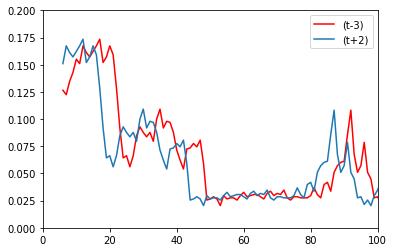

In [29]:
train_X['pollution(t-3)'].plot(c="red")
train_Y['pollution(t+2)'].plot()
plt.xlim([0,100])
plt.ylim([0,0.2])
plt.legend(['(t-3)','(t+2)'])

### Deep Learning models

### Multilayer perceptron

In [30]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import regularizers

In [31]:
output_file_name='Model_ANN_relu'

batch_size=72
epochs=50
output_size=3

In [32]:
os.makedirs('weights', exist_ok=True)

In [33]:
callbacks=[CSVLogger(output_file_name+'.csv', append=True),
                     ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5',
                                     monitor='val_loss', verbose=1,mode='min')]
#EarlyStoppingByLossVal(monitor='val_loss', value=7.93, verbose=1)
#TQDMNotebookCallback()

In [34]:
# 64 x 32 x 8, lambda = 0.01, he_uniform
    #kernel_initializer='he_uniform' больше подходит для функции активации ReLu
    # create model
model = Sequential()
model.add(Dense(64, input_shape=(33,), kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(8, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(output_size, kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('linear'))
    
model.compile(loss='mae', metrics=['mae'],
                  optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


In [35]:
history = model.fit(train_X.values, train_Y.values,
          batch_size=batch_size,
          validation_data=(train_X.values, train_Y.values),
          epochs = epochs,
          callbacks=callbacks,
                    shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 17512 samples, validate on 17512 samples
Epoch 1/50
17512/17512 [==============================] - ETA: 8:52 - loss: 2.1910 - mean_absolute_error: 0.102 - ETA: 47s - loss: 2.1281 - mean_absolute_error: 0.103 - ETA: 30s - loss: 2.0805 - mean_absolute_error: 0.09 - ETA: 18s - loss: 2.0010 - mean_absolute_error: 0.08 - ETA: 13s - loss: 1.9484 - mean_absolute_error: 0.07 - ETA: 10s - loss: 1.8818 - mean_absolute_error: 0.07 - ETA: 8s - loss: 1.8330 - mean_absolute_error: 0.0673 - ETA: 7s - loss: 1.7930 - mean_absolute_error: 0.065 - ETA: 6s - loss: 1.7380 - mean_absolute_error: 0.064 - ETA: 5s - loss: 1.7018 - mean_absolute_error: 0.064 - ETA: 4s - loss: 1.6508 - mean_absolute_error: 0.062 - ETA: 4s - loss: 1.6250 - mean_absolute_error: 0.065 - ETA: 3s - loss: 1.5763 - mean_absolute_error: 0.063 - ETA: 3s - loss: 1.5554 - mean_absolute_error: 0.065 - ETA: 3s - loss: 1.5160 - mean_absolute_error: 0.065 - ETA: 2s - loss: 1.4716 - mean_

17512/17512 [==============================] - ETA: 1s - loss: 0.0715 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0738 - mean_absolute_error: 0.028 - ETA: 1s - loss: 0.0744 - mean_absolute_error: 0.029 - ETA: 1s - loss: 0.0741 - mean_absolute_error: 0.029 - ETA: 1s - loss: 0.0731 - mean_absolute_error: 0.029 - ETA: 1s - loss: 0.0717 - mean_absolute_error: 0.028 - ETA: 1s - loss: 0.0711 - mean_absolute_error: 0.028 - ETA: 1s - loss: 0.0712 - mean_absolute_error: 0.028 - ETA: 0s - loss: 0.0714 - mean_absolute_error: 0.029 - ETA: 0s - loss: 0.0714 - mean_absolute_error: 0.029 - ETA: 0s - loss: 0.0724 - mean_absolute_error: 0.030 - ETA: 0s - loss: 0.0725 - mean_absolute_error: 0.030 - ETA: 0s - loss: 0.0732 - mean_absolute_error: 0.031 - ETA: 0s - loss: 0.0730 - mean_absolute_error: 0.031 - ETA: 0s - loss: 0.0720 - mean_absolute_error: 0.030 - ETA: 0s - loss: 0.0732 - mean_absolute_error: 0.031 - ETA: 0s - loss: 0.0724 - mean_absolute_error: 0.030 - ETA: 0s - loss: 0.0724 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0576 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0604 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0615 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0619 - mean_absolute_error: 0.027 - ETA: 1s - loss: 0.0603 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0593 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0593 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0595 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0596 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0600 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.028 - ETA: 0s - loss: 0.0607 - mean_absolute_error: 0.028 - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.028 - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.028 - ETA: 0s - loss: 0.0606 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.028 - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.028 - ETA: 0s - loss: 0.0609 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0542 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0584 - mean_absolute_error: 0.024 - ETA: 1s - loss: 0.0596 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0599 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0595 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0578 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0576 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0575 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0578 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0577 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0582 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0595 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0597 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0590 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0594 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0594 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0530 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0581 - mean_absolute_error: 0.024 - ETA: 1s - loss: 0.0590 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0594 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0589 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0571 - mean_absolute_error: 0.024 - ETA: 1s - loss: 0.0571 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0572 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0573 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0580 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0590 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0585 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0590 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0590 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0583 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0591 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0586 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0587 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0528 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0580 - mean_absolute_error: 0.024 - ETA: 1s - loss: 0.0590 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0591 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0591 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0573 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0572 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0569 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0571 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0570 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0575 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0585 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0582 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0590 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0585 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0581 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0589 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0526 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0585 - mean_absolute_error: 0.024 - ETA: 1s - loss: 0.0588 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0582 - mean_absolute_error: 0.024 - ETA: 1s - loss: 0.0589 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0574 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0571 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0570 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0571 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0573 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0578 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0581 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0585 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0581 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0580 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0527 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0577 - mean_absolute_error: 0.023 - ETA: 1s - loss: 0.0594 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0582 - mean_absolute_error: 0.024 - ETA: 1s - loss: 0.0591 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0586 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0578 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0570 - mean_absolute_error: 0.024 - ETA: 1s - loss: 0.0570 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0569 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0570 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0570 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0571 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0577 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0587 - mean_absolute_error: 0.027 - ETA: 1s - loss: 0.0581 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0588 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0586 - mean_absol

17512/17512 [==============================] - ETA: 3s - loss: 0.0529 - mean_absolute_error: 0.018 - ETA: 2s - loss: 0.0617 - mean_absolute_error: 0.027 - ETA: 2s - loss: 0.0578 - mean_absolute_error: 0.023 - ETA: 2s - loss: 0.0583 - mean_absolute_error: 0.024 - ETA: 2s - loss: 0.0590 - mean_absolute_error: 0.025 - ETA: 2s - loss: 0.0588 - mean_absolute_error: 0.025 - ETA: 2s - loss: 0.0596 - mean_absolute_error: 0.026 - ETA: 2s - loss: 0.0584 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0573 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0572 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0572 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0570 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0572 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0570 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0576 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0588 - mean_absolute_error: 0.027 - ETA: 1s - loss: 0.0581 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0587 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0532 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0580 - mean_absolute_error: 0.023 - ETA: 1s - loss: 0.0594 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0595 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0580 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0574 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0573 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0569 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0571 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0570 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0576 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0584 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0581 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0582 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0580 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0586 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0536 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0581 - mean_absolute_error: 0.023 - ETA: 1s - loss: 0.0592 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0593 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0593 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0577 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0573 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0572 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0571 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0574 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0579 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0581 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0582 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0581 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0586 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0535 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0580 - mean_absolute_error: 0.023 - ETA: 1s - loss: 0.0593 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0596 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0591 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0575 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0573 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0569 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0572 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0571 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0577 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0582 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0580 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0586 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0537 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0580 - mean_absolute_error: 0.023 - ETA: 1s - loss: 0.0593 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0600 - mean_absolute_error: 0.026 - ETA: 1s - loss: 0.0582 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0574 - mean_absolute_error: 0.025 - ETA: 1s - loss: 0.0572 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0572 - mean_absolute_error: 0.025 - ETA: 0s - loss: 0.0574 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0579 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0581 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0580 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.027 - ETA: 0s - loss: 0.0586 - mean_absolute_error: 0.026 - ETA: 0s - loss: 0.0586 - mean_absol

In [36]:
# loss и MAE различаются

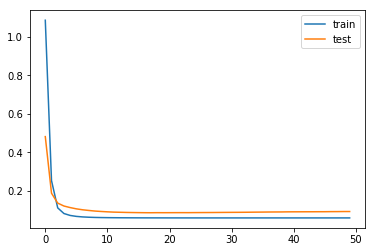

In [37]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
#plt.ylim([0.01,0.05])
plt.legend()
plt.show()

In [38]:
y_pred = model.predict(test_X.values)
y_pred1 = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))

inv_y_pred = scaler_y.inverse_transform(y_pred1)
y_pred = pd.DataFrame(inv_y_pred, columns=["pred(t+1)","pred(t+2)","pred(t+3)"])

y_fact = test_Y.values.reshape((len(test_Y), n_for))
inv_y_fact = scaler_y.inverse_transform(y_fact)
y_fact = pd.DataFrame(inv_y_fact, columns=["fact(t+1)","fact(t+2)","fact(t+3)"])

In [39]:
for i in range(0,n_for):
    rmse=np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_fact.iloc[:,i]))
    r2=r2_score(y_pred.iloc[:,i], y_fact.iloc[:,i])
    print('Test RMSE: %.3f' % rmse, 'Test R2: %.3f' % r2)

Test RMSE: 71.804 Test R2: 0.408
Test RMSE: 72.911 Test R2: 0.348
Test RMSE: 73.817 Test R2: 0.273


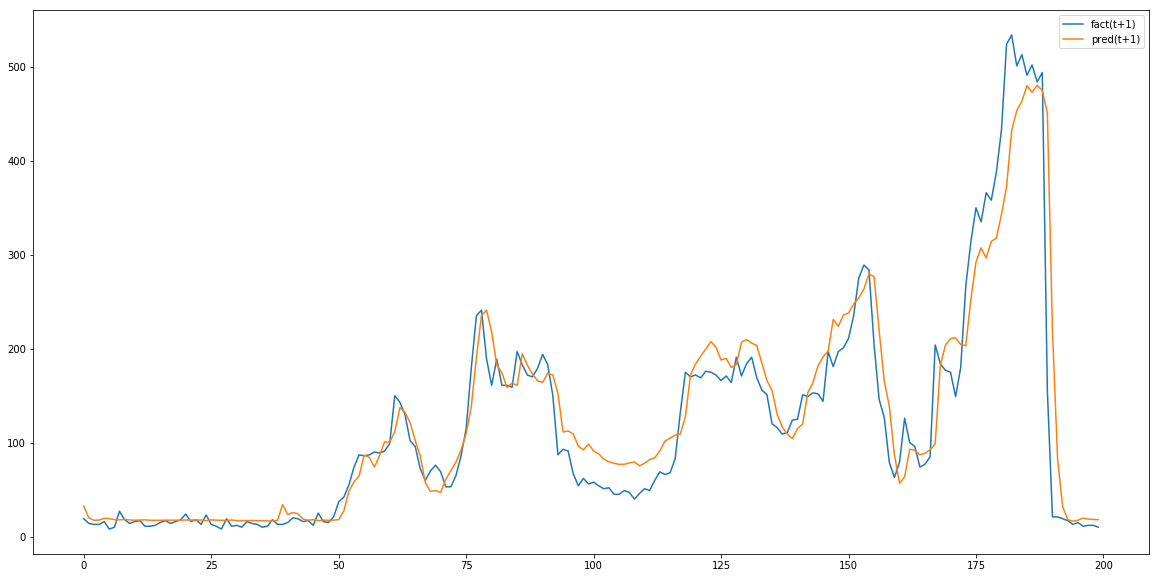

In [40]:
plt.figure(figsize=(20,10))
plt.plot(y_fact.iloc[:,0][:200])
plt.plot(y_pred.iloc[:,0][:200])
plt.legend()
plt.show()

### Long Short-Term Memory Networks

In [41]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.layers import LSTM, LeakyReLU
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import regularizers

output_file_name='Model_LSTM_relu'

units=50
batch_size=72
epochs=50
output_size=3
regb = regularizers.l2(0.01)
regW = regularizers.l2(0.001)

In [42]:
callbacks=[CSVLogger(output_file_name+'.csv', append=True),
                     ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5',
                                     monitor='val_loss', verbose=1,mode='min')]
#EarlyStoppingByLossVal(monitor='val_loss', value=7.93, verbose=1)
#TQDMNotebookCallback()

In [43]:
train_X = train_X.as_matrix().reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = test_X.as_matrix().reshape((test_X.shape[0],1,test_X.shape[1]))

train_Y = train_Y.as_matrix().reshape((train_Y.shape[0], train_Y.shape[1]))
test_Y = test_Y.as_matrix().reshape((test_Y.shape[0], test_Y.shape[1]))

https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss
    
#Remember - that if you use any kind of regularization - it affects your loss. Your actual loss is equal to:
#loss = mse + regularization
#and this is where your discrepancy comes from.

In [44]:
#build model
model = Sequential()
#model.add(LSTM(units=units, input_shape=(train_X.shape[1], train_X.shape[2]))), input_dim=32, 
#batch_input_shape=(batch_size,1,30), 
model.add(LSTM(units=units, input_dim=33, bias_regularizer=regb, recurrent_regularizer=regW, return_sequences=False))
model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Dense(output_size))
model.add(LeakyReLU())
model.compile(loss='mae', metrics=['mae'], optimizer='adam')
history = model.fit(train_X, train_Y,
          batch_size=batch_size,
          validation_data=(train_X, train_Y),
          epochs = epochs,
          callbacks=callbacks,
                    shuffle=False)

C:\Users\roma\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
C:\Users\roma\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, bias_regularizer=<keras.reg..., recurrent_regularizer=<keras.reg..., return_sequences=False, input_shape=(None, 33))`
  """


Train on 17512 samples, validate on 17512 samples
Epoch 1/50
17512/17512 [==============================] - ETA: 3:16 - loss: 0.6292 - mean_absolute_error: 0.079 - ETA: 25s - loss: 0.6351 - mean_absolute_error: 0.092 - ETA: 17s - loss: 0.6213 - mean_absolute_error: 0.08 - ETA: 11s - loss: 0.6171 - mean_absolute_error: 0.08 - ETA: 9s - loss: 0.6056 - mean_absolute_error: 0.0780 - ETA: 7s - loss: 0.5953 - mean_absolute_error: 0.073 - ETA: 6s - loss: 0.5888 - mean_absolute_error: 0.071 - ETA: 5s - loss: 0.5803 - mean_absolute_error: 0.068 - ETA: 4s - loss: 0.5711 - mean_absolute_error: 0.064 - ETA: 4s - loss: 0.5656 - mean_absolute_error: 0.062 - ETA: 4s - loss: 0.5590 - mean_absolute_error: 0.061 - ETA: 3s - loss: 0.5545 - mean_absolute_error: 0.060 - ETA: 3s - loss: 0.5493 - mean_absolute_error: 0.059 - ETA: 3s - loss: 0.5457 - mean_absolute_error: 0.059 - ETA: 3s - loss: 0.5412 - mean_absolute_error: 0.058 - ETA: 2s - loss: 0.5360 - mean_absolute_error: 0.058 - ETA: 2s - loss: 0.5356 -

17512/17512 [==============================] - ETA: 2s - loss: 0.0923 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.1003 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.1006 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0996 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.1007 - mean_absolute_error: 0.023 - ETA: 1s - loss: 0.0987 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0971 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0965 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0954 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0945 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0941 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0933 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0926 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0922 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0922 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0911 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0909 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0898 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0158 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0247 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0251 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0261 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0270 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0265 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0254 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0249 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0248 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0248 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0248 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0247 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0246 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0251 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0250 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0251 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0250 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0253 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0109 - mean_absolute_error: 0.010 - ETA: 1s - loss: 0.0197 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0223 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0222 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0213 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.010 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0193 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0221 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0213 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0194 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0220 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0194 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0220 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0219 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0210 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.011 - ETA: 2s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0182 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0219 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0193 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0198 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0219 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0115 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0192 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0197 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0218 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0115 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0192 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0181 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0218 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0190 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0218 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0112 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0190 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0213 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0198 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0190 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0194 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0198 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0112 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0189 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0194 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0198 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0112 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0189 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0193 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0112 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0188 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0178 - mean_absolute_error: 0.017 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absol

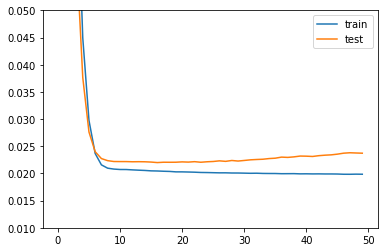

In [45]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim([0.01,0.05])
plt.legend()
plt.show()

In [46]:
y_pred = model.predict(test_X)
y_pred1 = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))

inv_y_pred = scaler_y.inverse_transform(y_pred1)
y_pred = pd.DataFrame(inv_y_pred, columns=["pred(t+1)","pred(t+2)","pred(t+3)"])

y_fact = test_Y.reshape((len(test_Y), n_for))
inv_y_fact = scaler_y.inverse_transform(y_fact)
y_fact = pd.DataFrame(inv_y_fact, columns=["fact(t+1)","fact(t+2)","fact(t+3)"])

In [47]:
for i in range(0,n_for):
    rmse=np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_fact.iloc[:,i]))
    r2=r2_score(y_pred.iloc[:,i], y_fact.iloc[:,i])
    print('Test RMSE: %.3f' % rmse, 'Test R2: %.3f' % r2)

Test RMSE: 28.299 Test R2: 0.907
Test RMSE: 38.614 Test R2: 0.817
Test RMSE: 50.206 Test R2: 0.679


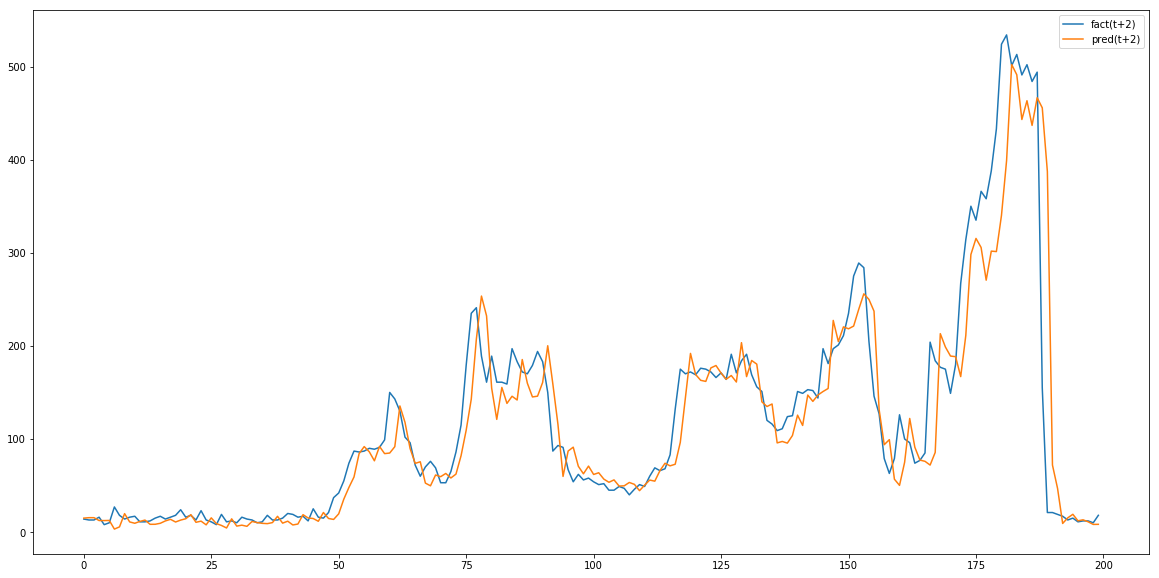

In [48]:
plt.figure(figsize=(20,10))
plt.plot(y_fact.iloc[:,1][:200])
plt.plot(y_pred.iloc[:,1][:200])
plt.legend()
plt.show()

### General Recurrent Unit 

In [49]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras.utils import np_utils
from keras.layers import GRU
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

output_file_name='Model_GRU_relu'

units=50
batch_size=72
epochs=50
output_size=3
regb = regularizers.l2(0.01)
regW = regularizers.l2(0.001)

In [50]:
callbacks=[CSVLogger(output_file_name+'.csv', append=True),
                     ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5',
                                     monitor='val_loss', verbose=1,mode='min')]
#EarlyStoppingByLossVal(monitor='val_loss', value=7.93, verbose=1)
#TQDMNotebookCallback()

In [51]:
#build model
model = Sequential()
model.add(GRU(units=units, input_dim=33,return_sequences=False))
model.add(Activation('tanh'))
#model.add(Dropout(0.2))
model.add(Dense(output_size))
model.add(Activation('relu'))
model.compile(loss='mae', metrics=['mae'], optimizer='adam')
history = model.fit(train_X, train_Y,
          batch_size=batch_size,
          validation_data=(test_X, test_Y),
          epochs = epochs,
          callbacks=callbacks,
                    shuffle=False)

C:\Users\roma\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\roma\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(units=50, return_sequences=False, input_shape=(None, 33))`
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 17512 samples, validate on 26263 samples
Epoch 1/50
17512/17512 [==============================] - ETA: 3:02 - loss: 0.0636 - mean_absolute_error: 0.063 - ETA: 21s - loss: 0.0783 - mean_absolute_error: 0.078 - ETA: 13s - loss: 0.0699 - mean_absolute_error: 0.06 - ETA: 9s - loss: 0.0708 - mean_absolute_error: 0.0708 - ETA: 7s - loss: 0.0688 - mean_absolute_error: 0.068 - ETA: 6s - loss: 0.0649 - mean_absolute_error: 0.064 - ETA: 5s - loss: 0.0626 - mean_absolute_error: 0.062 - ETA: 4s - loss: 0.0597 - mean_absolute_error: 0.059 - ETA: 4s - loss: 0.0577 - mean_absolute_error: 0.057 - ETA: 3s - loss: 0.0563 - mean_absolute_error: 0.056 - ETA: 3s - loss: 0.0549 - mean_absolute_error: 0.054 - ETA: 3s - loss: 0.0543 - mean_absolute_error: 0.054 - ETA: 2s - loss: 0.0535 - mean_absolute_error: 0.053 - ETA: 2s - loss: 0.0530 - mean_absolute_error: 0.053 - ETA: 2s - loss: 0.0521 - mean_absolute_error: 0.052 - ETA: 2s - loss: 0.0526 - mean_absolute_error: 0.052 - ETA: 2s - loss: 0.0509 -

17512/17512 [==============================] - ETA: 2s - loss: 0.0116 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 2s - loss: 0.0202 - mean_absolute_error: 0.020 - ETA: 2s - loss: 0.0221 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 2s - loss: 0.0232 - mean_absolute_error: 0.023 - ETA: 1s - loss: 0.0226 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0213 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0213 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0218 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0222 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0221 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0226 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0221 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0213 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0213 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0213 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0220 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0219 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0223 - mean_absolute_error: 0.022 - ETA: 0s - loss: 0.0224 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0198 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0224 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0220 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0219 - mean_absolute_error: 0.021 - ETA: 0s - loss: 0.0222 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0196 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0223 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0220 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0216 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0222 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0215 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0214 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0221 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0218 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0214 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0108 - mean_absolute_error: 0.010 - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0220 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0211 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0109 - mean_absolute_error: 0.010 - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0221 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0212 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0109 - mean_absolute_error: 0.010 - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0221 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0213 - mean_absol

17512/17512 [==============================] - ETA: 2s - loss: 0.0106 - mean_absolute_error: 0.010 - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0221 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0210 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.010 - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0183 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0219 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0211 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.010 - ETA: 1s - loss: 0.0197 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0221 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0210 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0114 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0222 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0218 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0212 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0197 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0222 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0220 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0211 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0196 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0183 - mean_absolute_error: 0.018 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0221 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0209 - mean_absol

17512/17512 [==============================] - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.011 - ETA: 1s - loss: 0.0196 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.019 - ETA: 1s - loss: 0.0209 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0221 - mean_absolute_error: 0.022 - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.021 - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0203 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0205 - mean_absolute_error: 0.020 - ETA: 1s - loss: 0.0209 - mean_absol

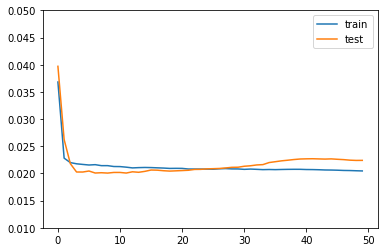

In [52]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim([0.01,0.05])
plt.legend()
plt.show()

In [53]:
y_pred = model.predict(test_X)
y_pred1 = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))

inv_y_pred = scaler_y.inverse_transform(y_pred1)
y_pred = pd.DataFrame(inv_y_pred, columns=["pred(t+1)","pred(t+2)","pred(t+3)"])

y_fact = test_Y.reshape((len(test_Y), n_for))
inv_y_fact = scaler_y.inverse_transform(y_fact)
y_fact = pd.DataFrame(inv_y_fact, columns=["fact(t+1)","fact(t+2)","fact(t+3)"])

In [54]:
for i in range(0,n_for):
    rmse=np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_fact.iloc[:,i]))
    r2=r2_score(y_pred.iloc[:,i], y_fact.iloc[:,i])
    print('Test RMSE: %.3f' % rmse, 'Test R2: %.3f' % r2)

Test RMSE: 25.718 Test R2: 0.916
Test RMSE: 37.772 Test R2: 0.824
Test RMSE: 48.543 Test R2: 0.695


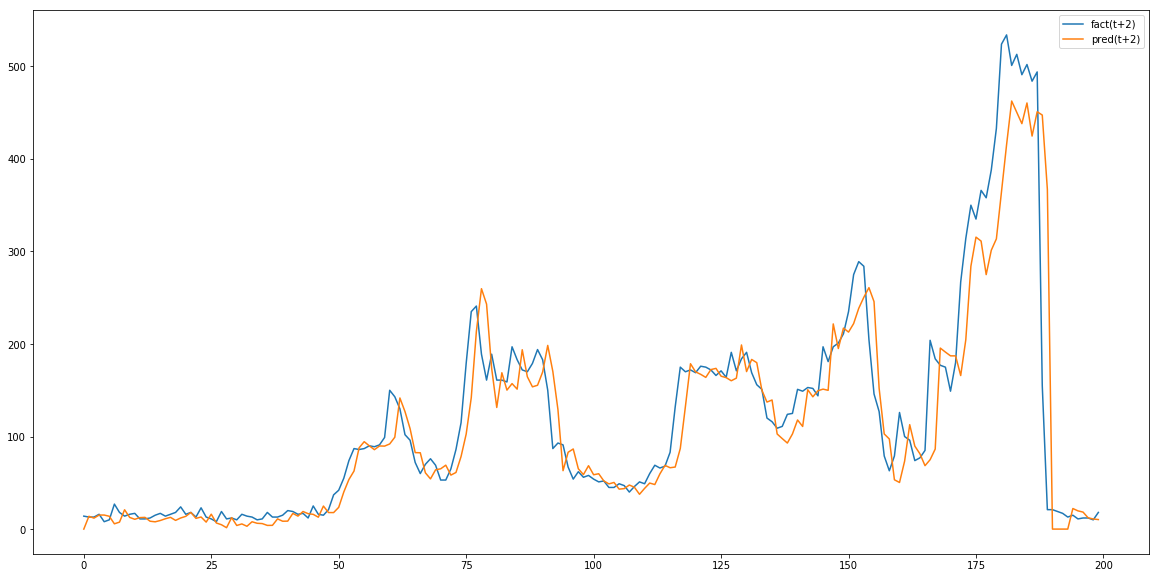

In [55]:
plt.figure(figsize=(20,10))
plt.plot(y_fact.iloc[:,1][:200])
plt.plot(y_pred.iloc[:,1][:200])
plt.legend()
plt.show()